# FSI of a zero-mass 2d ellipse swimming in quiescent viscous flow

In [1]:
using Revise
using BSON: @save, @load

using Pkg
Pkg.activate("..")
using FSI

┌ Info: Recompiling stale cache file /home/fs/.julia/compiled/v1.0/FSI/t27zx.ji for FSI [39fdbc7a-862a-11e9-015b-61723af7393f]
└ @ Base loading.jl:1190


In [2]:
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "2dSwim_zeromass_ellipse";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Function for generating ellipse with grid points

In [4]:
"""
    ellipse(z₀, a, b, h)
Constuct a ellipse in y-direction

# Arguments
- 'z₀' : head point location
- 'a' : semi-major axis
- 'b' : semi-minor axis
- 'h' : point interval in the major axis direction
"""
function ellipse(z₀::Array{Float64,2}, a::Float64, b::Float64, h::Float64)
    # first half
    verts = [0.0 -a]
    re = 2a
    y = -a
    while re > h
        y += h
        verts = [verts; [b*sqrt(1-(y/a)^2) y]]
        re -= h
    end
    # mid point
    verts = [verts; [0 a]]
    re = 2a
    y = a
    # second half
    while re > h
        y -= h
        verts = verts = [verts; [-b*sqrt(1-(y/a)^2) y]]
        re -= h
    end    
    verts[:,1] .+= z₀[1]
    verts[:,2] .+= z₀[2] + a  
    return verts
end

ellipse

#### Include any joint-body setup script from Dyn3d

In [5]:
# problem dimension
ndim = 2
# numerical params
tf = 4
dt = 1e-3
scheme = "Liska"
st = 5
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., 0., 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 3
ea = 0.5
eb = 0.05
verts = ellipse([0.0 0.0], ea, eb, 0.02)
nverts = size(verts,1)
config_body = ConfigBody(nbody, nverts, verts, 0.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.1;

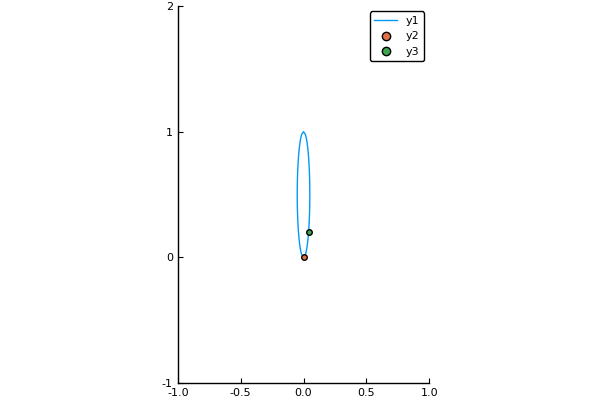

In [6]:
plot(verts[:,1],verts[:,2],aspect_ratio=1,xlim=(-1,1),ylim=(-1,2))
plot!([verts[1,1]],[verts[1,2]],seriestype=:scatter)
plot!([verts[11,1]],[verts[11,2]],seriestype=:scatter)

#### set the first passive planar joint with no stiff and damp

In [7]:
dof₁ = Vector{Dof}(undef,3)
[dof₁[i] = Dof(2*i, "passive", 0., 0., Motions()) for i = 1:3]
config_joints[1] = ConfigJoint(njoint, "custom_planar_in_y",
    [0.,0.,0.,0.6,0.,2.0], zeros(Float64,6), 0, dof₁, [0.0,0.0,0.0]);

#### set the second active joint with oscillatory motion

In [8]:
motion₂ = Motions("oscillatory", [-1.0, 1.0/(2*π), π/2])
dof₂ = Dof(2, "active", 0., 0., motion₂)
config_joints[2] = ConfigJoint(njoint, "custom_revolute_in_y",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   1, [dof₂], [0.]);

#### set the third active joint with oscillatory motion

In [9]:
motion₃ = Motions("oscillatory", [-1.0, 1.0/(2*π), -π])
dof₃ = Dof(2, "active", 0., 0., motion₃)
config_joints[3] = ConfigJoint(njoint, "custom_revolute_in_y",
   [0., 0., 0., 1.0+gap, 0., 0.],[0., 0., 0., -gap, 0., 0.],
   2, [dof₃], [0.]);

#### Build joint-body chain

In [10]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys);

#### Initialize rigid body system state to complete body-joint information

In [11]:
bd, soln₀ = InitSystem!(bd;influid=true);

#### Initialize u and λ container

In [12]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

#### Get body verts for plotting

In [13]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

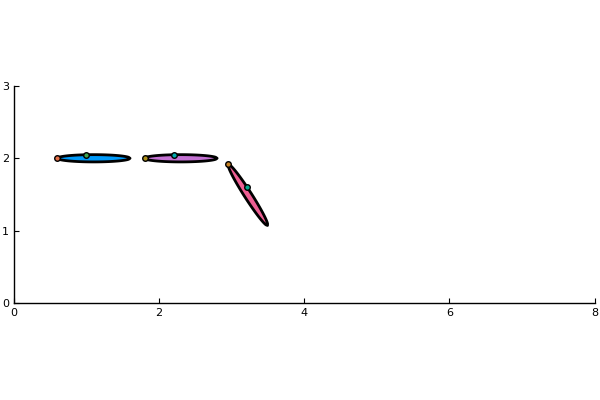

In [14]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,[1:nverts;1],1], vs₀[i,[1:nverts;1],3],linewidth=2,linecolor="black",fill=true)
    plot!(p,[vs₀[i,1,1]],[vs₀[i,1,3]],seriestype=:scatter)
    plot!(p,[vs₀[i,21,1]],[vs₀[i,21,3]],seriestype=:scatter)
end
plot!(xlims=(0,8), ylims=(0,3), ratio=1, legend=false)

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [15]:
Re = 200 # Reynolds number
U = 0.0 # Free stream velocity
U∞ = (0.0, U)

(0.0, 0.0)

#### Set the domain grid

In [16]:
nx = 402; ny = 152;
Ly = 3;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:8.01, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [17]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Body in fluid plane

In [18]:
plane = [1,3];

#### Genrate body grid points and get linear velocity on them

In [19]:
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx));

#### Get body points initial coordinates for fluids

In [20]:
bgs = AcquireBodyGridKinematics(bd,bgs);

#### Set up body grid points and force container in fluid

In [21]:
X̃ = BodyGridToVectorData(bgs,"coord";plane=plane)
f = VectorData(X̃);

#### Create fluidstruct structure

In [22]:
tf = 2500Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

300

## <span style="color:blue"> Create ifherk object </span>

In [23]:
@time ifherk_coupled = IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> FSI.Systems.plan_intfact(t,u,fsys), FSI.B₁ᵀ, FSI.B₂),
                (M, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx;plane=plane),
                 (bd,bgs,u) -> T₂(bd,bgs,u;plane=plane),
                 (bd,bgs) -> getX̃(bd,bgs;plane=plane)),
                ((w,t) -> FSI.r₁(w,t,fsys), bd -> F(bd,config_body.ρ), w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3, rk=FSI.TimeMarching.RK31, bodydim=2, ρb=config_body.ρ)

 38.469032 seconds (170.50 M allocations: 10.082 GiB, 4.08% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [24]:
fx = Float64[]
fy = Float64[]
t = 0.0
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [25]:
@time for ti in T
    
    @time global t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t-Δt)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is $(round(t,digits=3))")
    
end

 33.545791 seconds (147.38 M allocations: 9.123 GiB, 3.41% gc time)
next time unit is 0.01
 30.308119 seconds (138.83 M allocations: 8.811 GiB, 3.24% gc time)
next time unit is 0.02
 30.227971 seconds (138.83 M allocations: 8.811 GiB, 3.24% gc time)
next time unit is 0.03
 30.738695 seconds (138.83 M allocations: 8.811 GiB, 2.90% gc time)
next time unit is 0.04
 30.550065 seconds (138.83 M allocations: 8.811 GiB, 3.25% gc time)
next time unit is 0.05
 30.995973 seconds (138.83 M allocations: 8.811 GiB, 3.22% gc time)
next time unit is 0.06
 30.630566 seconds (138.83 M allocations: 8.811 GiB, 2.89% gc time)
next time unit is 0.07
 30.579086 seconds (138.83 M allocations: 8.811 GiB, 3.27% gc time)
next time unit is 0.08
 30.662716 seconds (138.83 M allocations: 8.811 GiB, 3.20% gc time)
next time unit is 0.09
 31.190964 seconds (138.83 M allocations: 8.811 GiB, 2.91% gc time)
next time unit is 0.1
 31.384808 seconds (138.83 M allocations: 8.811 GiB, 3.21% gc time)
next time unit is 0.11


 31.204842 seconds (138.83 M allocations: 8.811 GiB, 2.92% gc time)
next time unit is 0.92
 31.555031 seconds (138.83 M allocations: 8.811 GiB, 3.23% gc time)
next time unit is 0.93
 31.393850 seconds (138.83 M allocations: 8.811 GiB, 3.23% gc time)
next time unit is 0.94
 31.299786 seconds (138.83 M allocations: 8.811 GiB, 2.89% gc time)
next time unit is 0.95
 31.143802 seconds (138.83 M allocations: 8.811 GiB, 3.22% gc time)
next time unit is 0.96
 32.087482 seconds (138.83 M allocations: 8.811 GiB, 3.19% gc time)
next time unit is 0.97
 30.814619 seconds (138.83 M allocations: 8.811 GiB, 2.89% gc time)
next time unit is 0.98
 30.770701 seconds (138.83 M allocations: 8.811 GiB, 3.19% gc time)
next time unit is 0.99
 31.528387 seconds (138.83 M allocations: 8.811 GiB, 3.19% gc time)
next time unit is 1.0
 31.452481 seconds (138.83 M allocations: 8.811 GiB, 2.91% gc time)
next time unit is 1.01
 31.189417 seconds (138.83 M allocations: 8.811 GiB, 3.26% gc time)
next time unit is 1.02


 26.566378 seconds (138.83 M allocations: 8.811 GiB, 3.24% gc time)
next time unit is 1.83
 26.710736 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 1.84
 26.718154 seconds (138.83 M allocations: 8.811 GiB, 3.57% gc time)
next time unit is 1.85
 26.593545 seconds (138.83 M allocations: 8.811 GiB, 3.27% gc time)
next time unit is 1.86
 26.655036 seconds (138.83 M allocations: 8.811 GiB, 3.56% gc time)
next time unit is 1.87
 26.734642 seconds (138.83 M allocations: 8.811 GiB, 3.56% gc time)
next time unit is 1.88
 26.472256 seconds (138.83 M allocations: 8.811 GiB, 3.26% gc time)
next time unit is 1.89
 26.593799 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 1.9
 26.594887 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 1.91
 26.689887 seconds (138.83 M allocations: 8.811 GiB, 3.24% gc time)
next time unit is 1.92
 26.659083 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 1.93


 26.629390 seconds (138.83 M allocations: 8.811 GiB, 3.29% gc time)
next time unit is 2.74
 26.788535 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 2.75
 26.664149 seconds (138.83 M allocations: 8.811 GiB, 3.61% gc time)
next time unit is 2.76
 26.540315 seconds (138.83 M allocations: 8.811 GiB, 3.26% gc time)
next time unit is 2.77
 26.663245 seconds (138.83 M allocations: 8.811 GiB, 3.58% gc time)
next time unit is 2.78
 26.746781 seconds (138.83 M allocations: 8.811 GiB, 3.58% gc time)
next time unit is 2.79
 26.485264 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 2.8
 26.644120 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 2.81
 26.744989 seconds (138.83 M allocations: 8.811 GiB, 3.57% gc time)
next time unit is 2.82
 26.674935 seconds (138.83 M allocations: 8.811 GiB, 3.24% gc time)
next time unit is 2.83
 26.635227 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 2.84


 26.638191 seconds (138.83 M allocations: 8.811 GiB, 3.27% gc time)
next time unit is 3.65
 26.564434 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 3.66
 26.696641 seconds (138.83 M allocations: 8.811 GiB, 3.60% gc time)
next time unit is 3.67
 26.455713 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 3.68
 26.593304 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 3.69
 26.700739 seconds (138.83 M allocations: 8.811 GiB, 3.61% gc time)
next time unit is 3.7
 26.627140 seconds (138.83 M allocations: 8.811 GiB, 3.31% gc time)
next time unit is 3.71
 26.582873 seconds (138.83 M allocations: 8.811 GiB, 3.67% gc time)
next time unit is 3.72
 26.723763 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 3.73
 26.473636 seconds (138.83 M allocations: 8.811 GiB, 3.32% gc time)
next time unit is 3.74
 26.557076 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 3.75


 26.533097 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 4.56
 26.548440 seconds (138.83 M allocations: 8.811 GiB, 3.61% gc time)
next time unit is 4.57
 26.699487 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 4.58
 26.417523 seconds (138.83 M allocations: 8.811 GiB, 3.31% gc time)
next time unit is 4.59
 26.605175 seconds (138.83 M allocations: 8.811 GiB, 3.60% gc time)
next time unit is 4.6
 26.718405 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 4.61
 26.534084 seconds (138.83 M allocations: 8.811 GiB, 3.30% gc time)
next time unit is 4.62
 26.614123 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 4.63
 26.605438 seconds (138.83 M allocations: 8.811 GiB, 3.60% gc time)
next time unit is 4.64
 26.562968 seconds (138.83 M allocations: 8.811 GiB, 3.30% gc time)
next time unit is 4.65
 26.540478 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 4.66


 26.539496 seconds (138.83 M allocations: 8.811 GiB, 3.32% gc time)
next time unit is 5.47
 26.566937 seconds (138.83 M allocations: 8.811 GiB, 3.65% gc time)
next time unit is 5.48
 26.842154 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 5.49
 26.515109 seconds (138.83 M allocations: 8.811 GiB, 3.30% gc time)
next time unit is 5.5
 26.602943 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 5.51
 26.757628 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 5.52
 26.598579 seconds (138.83 M allocations: 8.811 GiB, 3.31% gc time)
next time unit is 5.53
 26.647868 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 5.54
 26.711141 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 5.55
 26.638394 seconds (138.83 M allocations: 8.811 GiB, 3.31% gc time)
next time unit is 5.56
 26.648697 seconds (138.83 M allocations: 8.811 GiB, 3.66% gc time)
next time unit is 5.57


 26.485517 seconds (138.83 M allocations: 8.811 GiB, 3.32% gc time)
next time unit is 6.38
 26.616957 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 6.39
 26.715862 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 6.4
 26.528611 seconds (138.83 M allocations: 8.811 GiB, 3.36% gc time)
next time unit is 6.41
 26.575662 seconds (138.83 M allocations: 8.811 GiB, 3.66% gc time)
next time unit is 6.42
 26.759006 seconds (138.83 M allocations: 8.811 GiB, 3.68% gc time)
next time unit is 6.43
 26.613852 seconds (138.83 M allocations: 8.811 GiB, 3.36% gc time)
next time unit is 6.44
 26.529228 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 6.45
 26.625093 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 6.46
 26.530820 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 6.47
 26.668109 seconds (138.83 M allocations: 8.811 GiB, 3.64% gc time)
next time unit is 6.48


 26.572845 seconds (138.83 M allocations: 8.811 GiB, 3.37% gc time)
next time unit is 7.29
 26.666217 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 7.3
 26.597393 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 7.31
 26.504154 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 7.32
 26.729740 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 7.33
 26.745464 seconds (138.83 M allocations: 8.811 GiB, 3.67% gc time)
next time unit is 7.34
 26.445007 seconds (138.83 M allocations: 8.811 GiB, 3.34% gc time)
next time unit is 7.35
 26.667360 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 7.36
 26.704299 seconds (138.83 M allocations: 8.811 GiB, 3.66% gc time)
next time unit is 7.37
 26.577962 seconds (138.83 M allocations: 8.811 GiB, 3.36% gc time)
next time unit is 7.38
 26.718955 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 7.39


 26.501662 seconds (138.83 M allocations: 8.811 GiB, 3.37% gc time)
next time unit is 8.2
 26.652621 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 8.21
 26.648373 seconds (138.83 M allocations: 8.811 GiB, 3.70% gc time)
next time unit is 8.22
 26.538760 seconds (138.83 M allocations: 8.811 GiB, 3.36% gc time)
next time unit is 8.23
 26.579329 seconds (138.83 M allocations: 8.811 GiB, 3.68% gc time)
next time unit is 8.24
 26.717773 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 8.25
 26.654052 seconds (138.83 M allocations: 8.811 GiB, 3.34% gc time)
next time unit is 8.26
 26.584315 seconds (138.83 M allocations: 8.811 GiB, 3.70% gc time)
next time unit is 8.27
 26.647864 seconds (138.83 M allocations: 8.811 GiB, 3.67% gc time)
next time unit is 8.28
 26.667649 seconds (138.83 M allocations: 8.811 GiB, 3.36% gc time)
next time unit is 8.29
 26.580548 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 8.3
 

 26.617470 seconds (138.83 M allocations: 8.811 GiB, 3.41% gc time)
next time unit is 9.11
 26.588753 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 9.12
 26.788421 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 9.13
 26.528302 seconds (138.83 M allocations: 8.811 GiB, 3.38% gc time)
next time unit is 9.14
 26.709676 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 9.15
 26.660678 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 9.16
 26.582664 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 9.17
 26.629180 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 9.18
 26.736710 seconds (138.83 M allocations: 8.811 GiB, 3.70% gc time)
next time unit is 9.19
 26.540538 seconds (138.83 M allocations: 8.811 GiB, 3.39% gc time)
next time unit is 9.2
 26.586494 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 9.21


 26.502268 seconds (138.83 M allocations: 8.811 GiB, 3.37% gc time)
next time unit is 10.02
 26.676391 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 10.03
 26.657679 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 10.04
 26.474758 seconds (138.83 M allocations: 8.811 GiB, 3.38% gc time)
next time unit is 10.05
 26.604742 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 10.06
 26.651331 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 10.07
 26.650295 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 10.08
 26.698164 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 10.09
 26.765062 seconds (138.83 M allocations: 8.811 GiB, 3.71% gc time)
next time unit is 10.1
 26.571320 seconds (138.83 M allocations: 8.811 GiB, 3.41% gc time)
next time unit is 10.11
 26.681705 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time uni

 26.607069 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 10.92
 26.433853 seconds (138.83 M allocations: 8.811 GiB, 3.42% gc time)
next time unit is 10.93
 26.640985 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time unit is 10.94
 26.695182 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 10.95
 26.614910 seconds (138.83 M allocations: 8.811 GiB, 3.41% gc time)
next time unit is 10.96
 26.636539 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 10.97
 26.740954 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 10.98
 26.696327 seconds (138.83 M allocations: 8.811 GiB, 3.42% gc time)
next time unit is 10.99
 26.616032 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 11.0
 26.673052 seconds (138.83 M allocations: 8.811 GiB, 3.73% gc time)
next time unit is 11.01
 26.519311 seconds (138.83 M allocations: 8.811 GiB, 3.40% gc time)
next time uni

 26.672254 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 11.82
 26.751606 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 11.83
 26.511419 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 11.84
 26.680893 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 11.85
 26.798460 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time unit is 11.86
 26.595350 seconds (138.83 M allocations: 8.811 GiB, 3.42% gc time)
next time unit is 11.87
 26.676678 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 11.88
 26.782354 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 11.89
 26.567029 seconds (138.83 M allocations: 8.811 GiB, 3.40% gc time)
next time unit is 11.9
 26.628167 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 11.91
 26.798166 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time uni

 26.609354 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 12.72
 26.676322 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 12.73
 26.714248 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 12.74
 26.554255 seconds (138.83 M allocations: 8.811 GiB, 3.41% gc time)
next time unit is 12.75
 26.694154 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 12.76
 26.692426 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 12.77
 26.592010 seconds (138.83 M allocations: 8.811 GiB, 3.42% gc time)
next time unit is 12.78
 26.716799 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 12.79
 26.701218 seconds (138.83 M allocations: 8.811 GiB, 3.74% gc time)
next time unit is 12.8
 26.517547 seconds (138.83 M allocations: 8.811 GiB, 3.40% gc time)
next time unit is 12.81
 26.661679 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time uni

 26.660928 seconds (138.83 M allocations: 8.811 GiB, 3.41% gc time)
next time unit is 13.62
 26.656198 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time unit is 13.63
 26.771085 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time unit is 13.64
 26.766475 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 13.65
 26.614166 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 13.66
 26.701415 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 13.67
 26.788899 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 13.68
 26.600358 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 13.69
 26.695843 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 13.7
 26.710369 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time unit is 13.71
 26.641580 seconds (138.83 M allocations: 8.811 GiB, 3.42% gc time)
next time uni

 26.704252 seconds (138.83 M allocations: 8.811 GiB, 3.82% gc time)
next time unit is 14.52
 26.686084 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 14.53
 26.648861 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 14.54
 26.709084 seconds (138.83 M allocations: 8.811 GiB, 3.82% gc time)
next time unit is 14.55
 26.704939 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 14.56
 26.506607 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time unit is 14.57
 26.780024 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 14.58
 26.733904 seconds (138.83 M allocations: 8.811 GiB, 3.84% gc time)
next time unit is 14.59
 26.486659 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time unit is 14.6
 26.652632 seconds (138.83 M allocations: 8.811 GiB, 3.82% gc time)
next time unit is 14.61
 26.635947 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time uni

 26.641051 seconds (138.83 M allocations: 8.811 GiB, 3.83% gc time)
next time unit is 15.42
 26.711910 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 15.43
 26.603500 seconds (138.83 M allocations: 8.811 GiB, 3.47% gc time)
next time unit is 15.44
 26.679289 seconds (138.83 M allocations: 8.811 GiB, 3.82% gc time)
next time unit is 15.45
 26.687894 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 15.46
 26.645035 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 15.47
 26.526284 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 15.48
 26.742903 seconds (138.83 M allocations: 8.811 GiB, 3.83% gc time)
next time unit is 15.49
 26.751092 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 15.5
 26.583594 seconds (138.83 M allocations: 8.811 GiB, 3.45% gc time)
next time unit is 15.51
 26.692908 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time uni

 26.664678 seconds (138.83 M allocations: 8.811 GiB, 3.44% gc time)
next time unit is 16.32
 26.841765 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 16.33
 26.741335 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 16.34
 26.600327 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time unit is 16.35
 26.595066 seconds (138.83 M allocations: 8.811 GiB, 3.87% gc time)
next time unit is 16.36
 26.732557 seconds (138.83 M allocations: 8.811 GiB, 3.84% gc time)
next time unit is 16.37
 26.835851 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 16.38
 26.594860 seconds (138.83 M allocations: 8.811 GiB, 3.48% gc time)
next time unit is 16.39
 26.682559 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 16.4
 26.773900 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 16.41
 26.581965 seconds (138.83 M allocations: 8.811 GiB, 3.47% gc time)
next time uni

 26.768946 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 17.22
 26.695311 seconds (138.83 M allocations: 8.811 GiB, 3.49% gc time)
next time unit is 17.23
 26.661306 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 17.24
 26.702617 seconds (138.83 M allocations: 8.811 GiB, 3.82% gc time)
next time unit is 17.25
 26.582379 seconds (138.83 M allocations: 8.811 GiB, 3.51% gc time)
next time unit is 17.26
 26.661296 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 17.27
 26.669909 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 17.28
 26.766633 seconds (138.83 M allocations: 8.811 GiB, 3.83% gc time)
next time unit is 17.29
 26.516012 seconds (138.83 M allocations: 8.811 GiB, 3.50% gc time)
next time unit is 17.3
 26.704961 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 17.31
 26.751170 seconds (138.83 M allocations: 8.811 GiB, 3.87% gc time)
next time uni

 26.720196 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 18.12
 26.812049 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 18.13
 26.663856 seconds (138.83 M allocations: 8.811 GiB, 3.49% gc time)
next time unit is 18.14
 26.760525 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 18.15
 26.707264 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 18.16
 26.736674 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time unit is 18.17
 26.699432 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 18.18
 26.709884 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 18.19
 26.721616 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 18.2
 26.643135 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time unit is 18.21
 26.658518 seconds (138.83 M allocations: 8.811 GiB, 3.87% gc time)
next time uni

 26.585466 seconds (138.83 M allocations: 8.811 GiB, 3.49% gc time)
next time unit is 19.02
 26.715424 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 19.03
 26.735940 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 19.04
 26.625093 seconds (138.83 M allocations: 8.811 GiB, 3.48% gc time)
next time unit is 19.05
 26.755567 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 19.06
 26.750042 seconds (138.83 M allocations: 8.811 GiB, 3.83% gc time)
next time unit is 19.07
 26.708872 seconds (138.83 M allocations: 8.811 GiB, 3.48% gc time)
next time unit is 19.08
 26.656955 seconds (138.83 M allocations: 8.811 GiB, 3.91% gc time)
next time unit is 19.09
 26.801026 seconds (138.83 M allocations: 8.811 GiB, 3.88% gc time)
next time unit is 19.1
 26.781512 seconds (138.83 M allocations: 8.811 GiB, 3.85% gc time)
next time unit is 19.11
 26.653751 seconds (138.83 M allocations: 8.811 GiB, 3.46% gc time)
next time uni

 26.761792 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 19.92
 26.548712 seconds (138.83 M allocations: 8.811 GiB, 3.51% gc time)
next time unit is 19.93
 26.739529 seconds (138.83 M allocations: 8.811 GiB, 3.86% gc time)
next time unit is 19.94
 26.803501 seconds (138.83 M allocations: 8.811 GiB, 3.88% gc time)
next time unit is 19.95
 26.712051 seconds (138.83 M allocations: 8.811 GiB, 3.48% gc time)
next time unit is 19.96
 26.784598 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 19.97
 26.783129 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 19.98
 26.635891 seconds (138.83 M allocations: 8.811 GiB, 3.54% gc time)
next time unit is 19.99
 26.682909 seconds (138.83 M allocations: 8.811 GiB, 3.88% gc time)
next time unit is 20.0
 26.814186 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 20.01
 26.810756 seconds (138.83 M allocations: 8.811 GiB, 3.84% gc time)
next time uni

 26.723536 seconds (138.83 M allocations: 8.811 GiB, 3.92% gc time)
next time unit is 20.82
 26.763967 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 20.83
 26.586754 seconds (138.83 M allocations: 8.811 GiB, 3.53% gc time)
next time unit is 20.84
 26.761378 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 20.85
 26.933981 seconds (138.83 M allocations: 8.811 GiB, 3.88% gc time)
next time unit is 20.86
 26.762487 seconds (138.83 M allocations: 8.811 GiB, 3.51% gc time)
next time unit is 20.87
 26.825698 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 20.88
 26.732491 seconds (138.83 M allocations: 8.811 GiB, 3.89% gc time)
next time unit is 20.89
 26.683357 seconds (138.83 M allocations: 8.811 GiB, 3.52% gc time)
next time unit is 20.9
 26.812193 seconds (138.83 M allocations: 8.811 GiB, 3.93% gc time)
next time unit is 20.91
 26.790428 seconds (138.83 M allocations: 8.811 GiB, 3.93% gc time)
next time uni

 31.085232 seconds (138.83 M allocations: 8.811 GiB, 3.22% gc time)
next time unit is 21.72
 31.139429 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 21.73
 31.441846 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 21.74
 31.460714 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 21.75
 32.104338 seconds (138.83 M allocations: 8.811 GiB, 3.58% gc time)
next time unit is 21.76
 31.561661 seconds (138.83 M allocations: 8.811 GiB, 3.68% gc time)
next time unit is 21.77
 31.656895 seconds (138.83 M allocations: 8.811 GiB, 3.27% gc time)
next time unit is 21.78
 31.839398 seconds (138.83 M allocations: 8.811 GiB, 3.67% gc time)
next time unit is 21.79
 31.959661 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 21.8
 31.866122 seconds (138.83 M allocations: 8.811 GiB, 3.18% gc time)
next time unit is 21.81
 31.828259 seconds (138.83 M allocations: 8.811 GiB, 3.65% gc time)
next time uni

 32.728919 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 22.62
 32.192584 seconds (138.83 M allocations: 8.811 GiB, 3.27% gc time)
next time unit is 22.63
 32.977674 seconds (138.83 M allocations: 8.811 GiB, 3.62% gc time)
next time unit is 22.64
 33.150056 seconds (138.83 M allocations: 8.811 GiB, 3.57% gc time)
next time unit is 22.65
 32.440856 seconds (138.83 M allocations: 8.811 GiB, 3.22% gc time)
next time unit is 22.66
 32.237177 seconds (138.83 M allocations: 8.811 GiB, 3.65% gc time)
next time unit is 22.67
 31.945429 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 22.68
 32.130130 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 22.69
 32.886906 seconds (138.83 M allocations: 8.811 GiB, 3.63% gc time)
next time unit is 22.7
 33.001565 seconds (138.83 M allocations: 8.811 GiB, 3.53% gc time)
next time unit is 22.71
 32.315036 seconds (138.83 M allocations: 8.811 GiB, 3.25% gc time)
next time uni

 32.236204 seconds (138.83 M allocations: 8.811 GiB, 3.66% gc time)
next time unit is 23.52
 32.456064 seconds (138.83 M allocations: 8.811 GiB, 3.72% gc time)
next time unit is 23.53
 32.145923 seconds (138.83 M allocations: 8.811 GiB, 3.32% gc time)
next time unit is 23.54
 32.809169 seconds (138.83 M allocations: 8.811 GiB, 3.81% gc time)
next time unit is 23.55
 32.658622 seconds (138.83 M allocations: 8.811 GiB, 3.59% gc time)
next time unit is 23.56
 32.083564 seconds (138.83 M allocations: 8.811 GiB, 3.28% gc time)
next time unit is 23.57
 32.855613 seconds (138.83 M allocations: 8.811 GiB, 3.67% gc time)
next time unit is 23.58
 33.300732 seconds (138.83 M allocations: 8.811 GiB, 3.65% gc time)
next time unit is 23.59
 32.390918 seconds (138.83 M allocations: 8.811 GiB, 3.25% gc time)
next time unit is 23.6
 32.680494 seconds (138.83 M allocations: 8.811 GiB, 3.61% gc time)
next time unit is 23.61
 32.609596 seconds (138.83 M allocations: 8.811 GiB, 3.65% gc time)
next time uni

 28.389498 seconds (138.83 M allocations: 8.811 GiB, 3.78% gc time)
next time unit is 24.42
 28.411196 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 24.43
 28.299097 seconds (138.83 M allocations: 8.811 GiB, 3.76% gc time)
next time unit is 24.44
 28.228926 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 24.45
 28.411013 seconds (138.83 M allocations: 8.811 GiB, 3.80% gc time)
next time unit is 24.46
 28.458796 seconds (138.83 M allocations: 8.811 GiB, 3.75% gc time)
next time unit is 24.47
 28.085363 seconds (138.83 M allocations: 8.811 GiB, 3.38% gc time)
next time unit is 24.48
 28.221303 seconds (138.83 M allocations: 8.811 GiB, 3.77% gc time)
next time unit is 24.49
 29.064987 seconds (138.83 M allocations: 8.811 GiB, 3.69% gc time)
next time unit is 24.5
 28.445741 seconds (138.83 M allocations: 8.811 GiB, 3.35% gc time)
next time unit is 24.51
 27.916013 seconds (138.83 M allocations: 8.811 GiB, 3.79% gc time)
next time uni

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [26]:
contour_levels = range(-5*Δx,stop=5*Δx,length=40)
sample_rate = 5
clims = (-5*Δx,5*Δx)
fps = 25;

In [27]:
# contour_levels = range(0.5*minimum(w.data),stop=0.5*maximum(w.data),length=40)
# sample_rate = 5
# clims = (0.5*minimum(w.data),0.5*maximum(w.data))
# fps = 25;

In [28]:
contour_levels

-0.1:0.005128205128205128:0.1

#### Get body verts history

In [29]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end
fb = [1:nverts;1];

#### Plot first and last time field

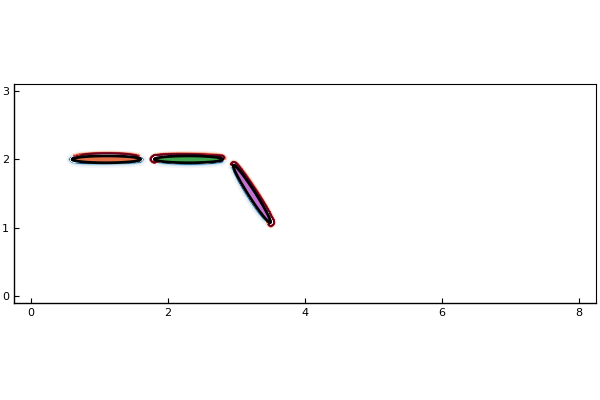

In [30]:
p = plot(xg,yg,whist[1],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,fb,plane[1]], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

#### 0.8T

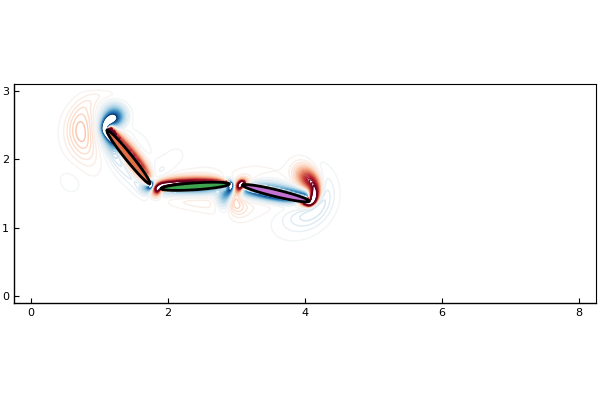

In [31]:
kk = 502
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,fb,plane[1]], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

#### 1.6T

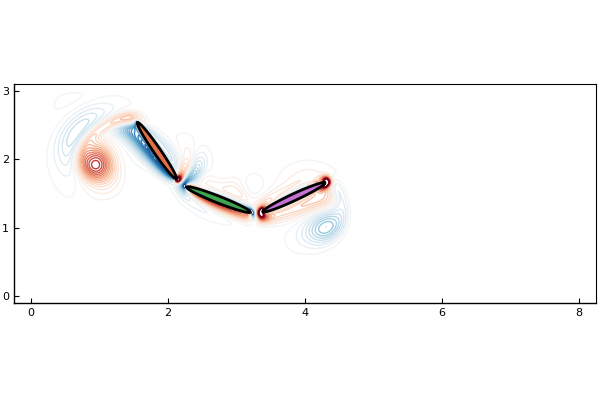

In [32]:
kk = 1005
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,fb,plane[1]], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

#### 2.39T

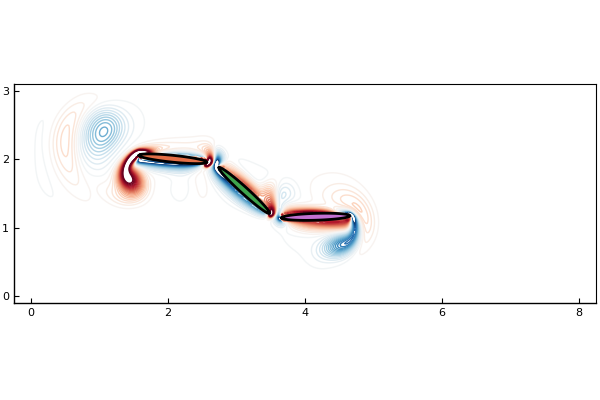

In [33]:
kk = 1501
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,fb,plane[1]], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

#### 3.18T

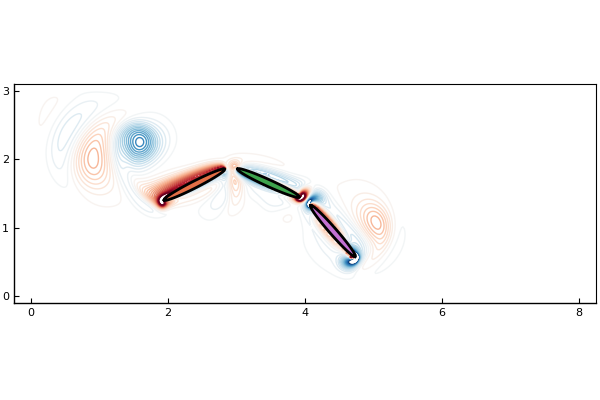

In [34]:
kk = 1998
p = plot(xg,yg,whist[kk],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[kk][i,fb,plane[1]], vshist[kk][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
p

#### 3.98T

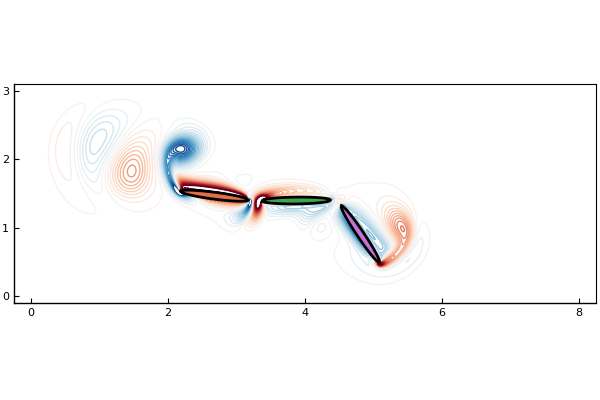

In [35]:
p = plot(xg,yg,whist[end],levels=contour_levels,color=:RdBu_r,clims=clims)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,fb,plane[1]], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
end
# savefig(p,"plate.eps")
p

#### Body position begining and end

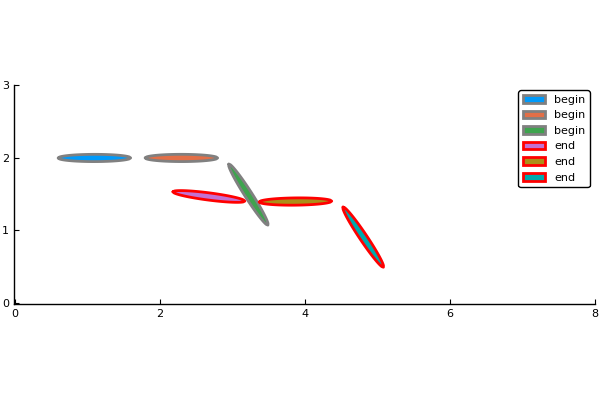

In [36]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,fb,1], vshist[1][i,fb,plane[2]],linewidth=2,linecolor="grey",label="begin",fill=true)
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,fb,1], vshist[end][i,fb,plane[2]],linewidth=2,linecolor="red",label="end",fill=true)
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]),ratio=1)
pb

#### gif with tail

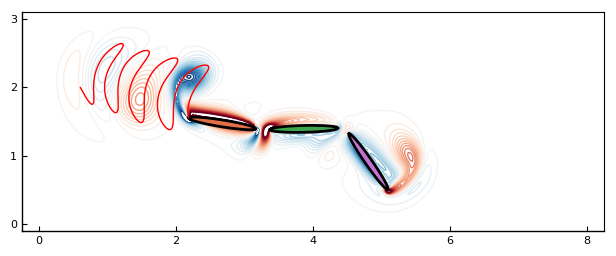

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/tmp10.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/tmp10.gif")

In [37]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,plane[1]], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
    end
    push!(v1_x,vshist[j][1,1,plane[1]])
    push!(v1_y,vshist[j][1,1,plane[2]])
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*".gif", fps = fps)

#### gif with 2nd body's center

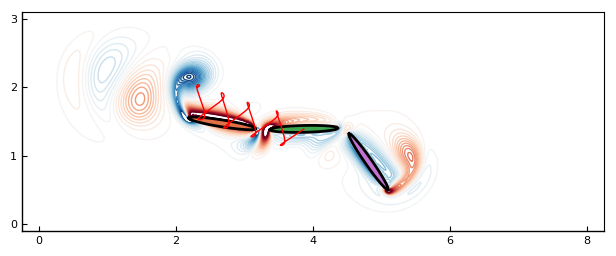

┌ Info: Saved animation to 
│   fn = /mnt/g/Research/FSI.jl/examples/tmp10_center.gif
└ @ Plots /home/fs/.julia/packages/Plots/oiirH/src/animation.jl:90


Plots.AnimatedGif("/mnt/g/Research/FSI.jl/examples/tmp10_center.gif")

In [61]:
v1_x = []
v1_y = []

anim = @animate for j = 1:sample_rate:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels,color=:RdBu_r,clims=clims)
    for i = 1:sys.nbody
        plot!(vshist[j][i,fb,plane[1]], vshist[j][i,fb,plane[2]],linewidth=2,linecolor="black", fill=true)
    end
    push!(v1_x,0.5*(vshist[j][2,1,1]+vshist[j][2,51,1]))
    push!(v1_y,0.5*(vshist[j][2,1,3]+vshist[j][2,51,3]))
    plot!(v1_x,v1_y,linecolor="red")
end

gif(anim, filename*"_center.gif", fps = fps)

#### Lift and drag coefficient

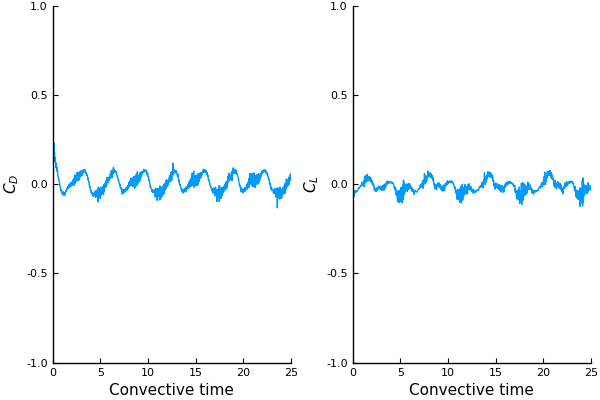

In [78]:
px = plot(thist,2*fx,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,xlim=(0,25),ylim=(-1,1),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

#### position of the central body

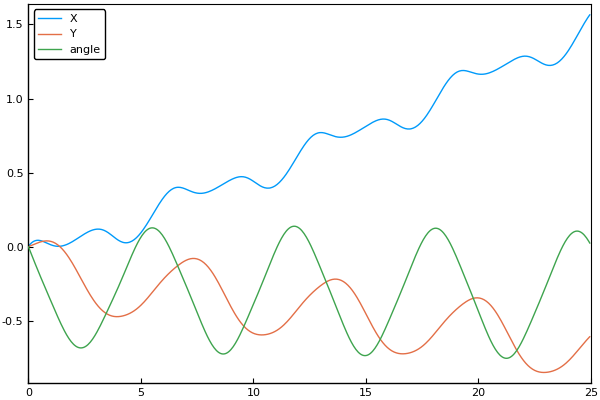

In [77]:
v2_x = []
v2_y = []
α2 = []
t_sampled = []
cnt = 1

for j = 1:sample_rate:length(whist)
    push!(t_sampled,thist[j])
    push!(v2_x,0.5*(vshist[j][2,1,1]+vshist[j][2,51,1])-2.3)
    push!(v2_y,0.5*(vshist[j][2,1,3]+vshist[j][2,51,3])-2)
    push!(α2,atan((v2_y[cnt]+2-vshist[j][2,1,3])/(v2_x[cnt]+2.3-vshist[j][2,1,1])))
    cnt += 1
end

plot(t_sampled,v2_x,label="X", framestyle = :box,xlim=(0,25))
plot!(t_sampled,v2_y,label="Y")
plot!(t_sampled,α2,label="angle")

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .bson file

In [43]:
# @save filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f

#### Use the following block to extract data

In [41]:
# using Dyn3d
# using ViscousFlow

# @load filename*".bson" bd bdhist xg yg whist vshist thist fx fy Δt w qJ v t f
# @get bd (bs,js,sys);

In [42]:
t

25.00000000000111